# Dataset Creation


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# Set random seed for reproducibility
np.random.seed(42)

# Configuration: Number of suppliers, customers, and warehouses
NUM_SUPPLIERS = 6
NUM_CUSTOMERS = 10
NUM_WAREHOUSES = 3
WAREHOUSE_CAPACITY = 500

# Generate supplier dataset with random supplying capacity
suppliers = pd.DataFrame({
    'Supplier_ID': [f'S{i}' for i in range(1, NUM_SUPPLIERS + 1)],
    'Location_X': np.random.uniform(0, 100, NUM_SUPPLIERS).round(2),
    'Location_Y': np.random.uniform(0, 100, NUM_SUPPLIERS).round(2),
    'Supplying_Capacity': np.random.randint(50, 200, NUM_SUPPLIERS)  # Random capacity between 50 and 200
})

# Generate customer dataset
customers = pd.DataFrame({
    'Customer_ID': [f'C{i}' for i in range(1, NUM_CUSTOMERS + 1)],
    'Location_X': np.random.uniform(0, 100, NUM_CUSTOMERS).round(2),
    'Location_Y': np.random.uniform(0, 100, NUM_CUSTOMERS).round(2),
    'Demand': np.random.randint(10, 50, NUM_CUSTOMERS)
})

# Combine supplier and customer locations
all_locations = pd.concat([suppliers[['Location_X', 'Location_Y']], customers[['Location_X', 'Location_Y']]])

# Apply K-Means clustering to determine warehouse locations
kmeans = KMeans(n_clusters=NUM_WAREHOUSES, random_state=42, n_init=10)
kmeans.fit(all_locations)
warehouse_locations = kmeans.cluster_centers_

# Generate warehouse dataset
warehouses = pd.DataFrame({
    'Warehouse_ID': [f'W{i+1}' for i in range(NUM_WAREHOUSES)],
    'Location_X': warehouse_locations[:, 0].round(2),
    'Location_Y': warehouse_locations[:, 1].round(2),
    'Capacity': [WAREHOUSE_CAPACITY] * NUM_WAREHOUSES
})

# Generate routes dataset
locations = suppliers[['Supplier_ID', 'Location_X', 'Location_Y']].rename(columns={'Supplier_ID': 'ID'})
locations = pd.concat([locations, customers[['Customer_ID', 'Location_X', 'Location_Y']].rename(columns={'Customer_ID': 'ID'})])

# Assign each location to the nearest warehouse
def find_nearest_warehouse(x, y, warehouse_df):
    distances = np.linalg.norm(warehouse_df[['Location_X', 'Location_Y']].values - np.array([x, y]), axis=1)
    return warehouse_df.loc[np.argmin(distances), 'Warehouse_ID']

routes = pd.DataFrame({
    'Route_ID': [f'R{i+1}' for i in range(len(locations))],
    'Start_Location': locations['ID'].values,
    'End_Location': locations.apply(lambda row: find_nearest_warehouse(row['Location_X'], row['Location_Y'], warehouses), axis=1)
})
routes['Distance'] = locations.apply(lambda row: np.linalg.norm(
    warehouses.loc[warehouses['Warehouse_ID'] == find_nearest_warehouse(row['Location_X'], row['Location_Y'], warehouses), ['Location_X', 'Location_Y']].values - np.array([row['Location_X'], row['Location_Y']]), axis=1
), axis=1).round(2)

# Save all datasets efficiently
file_paths = {
    'suppliers.csv': suppliers,
    'customers.csv': customers,
    'warehouse.csv': warehouses,
    'routes.csv': routes
}

for file_name, df in file_paths.items():
    df.to_csv(file_name, index=False)

print("Datasets created and saved successfully:")
for file_name in file_paths.keys():
    print(f"- {file_name}")


Datasets created and saved successfully:
- suppliers.csv
- customers.csv
- warehouse.csv
- routes.csv


In [ ]:
# Displaying basic structure of all datasets
print(" Suppliers Dataset Structure ")
# DataFrame structure summary
print(suppliers.head())  # First few rows

print("\n Customers Dataset Structure ")

print(customers.head())

print("\n Warehouse Dataset Structure ")

print(warehouses.head())

print("\n Routes Dataset Structure ")
print(routes.head())


 Suppliers Dataset Structure 
  Supplier_ID  Location_X  Location_Y  Supplying_Capacity
0          S1       37.45        5.81                  87
1          S2       95.07       86.62                 179
2          S3       73.20       60.11                  70
3          S4       59.87       70.81                 107
4          S5       15.60        2.06                  71

 Customers Dataset Structure 
  Customer_ID  Location_X  Location_Y  Demand
0          C1       29.12        4.65      16
1          C2       61.19       60.75      17
2          C3       13.95       17.05      44
3          C4       29.21        6.51      23
4          C5       36.64       94.89      26

 Warehouse Dataset Structure 
  Warehouse_ID  Location_X  Location_Y  Capacity
0           W1       32.62       96.15       500
1           W2       28.10       10.90       500
2           W3       71.18       71.26       500

 Routes Dataset Structure 
  Route_ID Start_Location End_Location              Distance

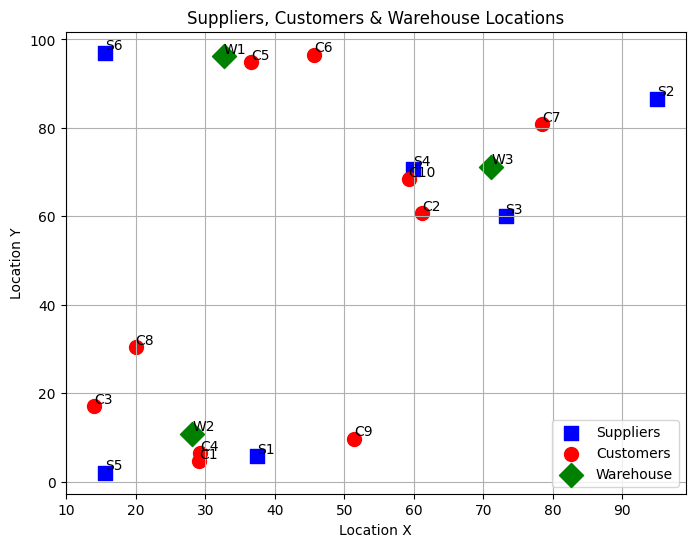

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load datasets
suppliers = pd.read_csv("suppliers.csv")
customers = pd.read_csv("customers.csv")
warehouse = pd.read_csv("warehouse.csv")

# Plot locations
plt.figure(figsize=(8, 6))
plt.scatter(suppliers["Location_X"], suppliers["Location_Y"], color='blue', label="Suppliers", marker='s', s=100)
plt.scatter(customers["Location_X"], customers["Location_Y"], color='red', label="Customers", marker='o', s=100)
plt.scatter(warehouse["Location_X"], warehouse["Location_Y"], color='green', label="Warehouse", marker='D', s=150)

# Annotate points
for i, row in suppliers.iterrows():
    plt.text(row["Location_X"], row["Location_Y"], f"S{i+1}", fontsize=10, verticalalignment='bottom')

for i, row in customers.iterrows():
    plt.text(row["Location_X"], row["Location_Y"], f"C{i+1}", fontsize=10, verticalalignment='bottom')

for i, row in warehouse.iterrows():
    plt.text(row["Location_X"], row["Location_Y"], f"W{i+1}", fontsize=10, verticalalignment='bottom')

plt.xlabel("Location X")
plt.ylabel("Location Y")
plt.title("Suppliers, Customers & Warehouse Locations")
plt.legend()
plt.grid(True)
plt.show()



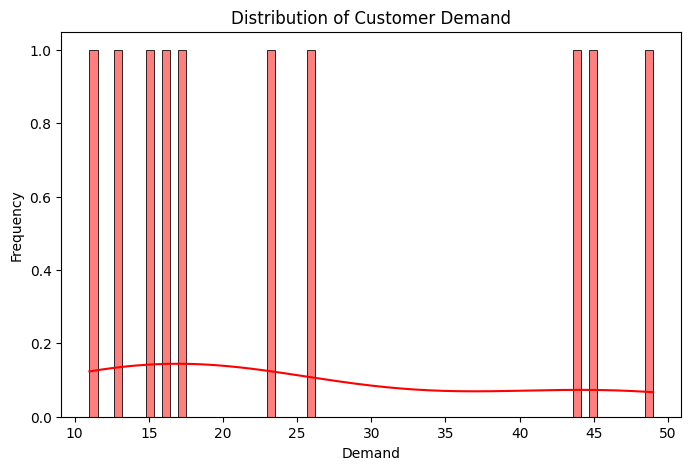

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import Seaborn

# Plot the distribution of customer demand
plt.figure(figsize=(8, 5))
sns.histplot(customers["Demand"], bins=70, kde=True, color="red")
plt.xlabel("Demand")
plt.ylabel("Frequency")
plt.title("Distribution of Customer Demand")
plt.show()



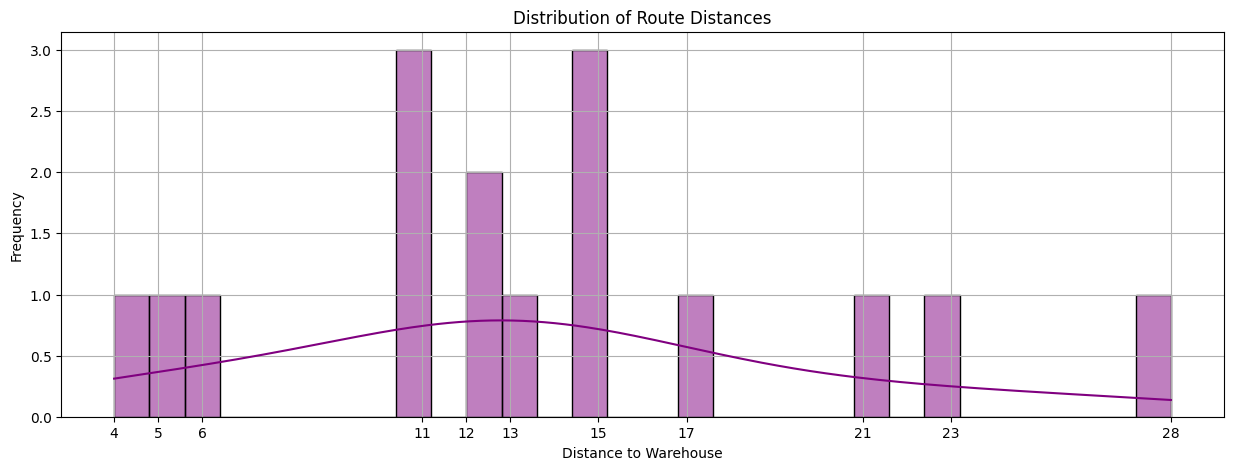

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load dataset
routes = pd.read_csv("routes.csv")

# Ensure 'Distance' column is numeric and convert to integers
routes["Distance"] = routes["Distance"].apply(lambda x: float(x.strip("[]")) if isinstance(x, str) else x)  # Convert strings with brackets to float
routes["Distance"] = pd.to_numeric(routes["Distance"], errors='coerce').round().astype('Int64')  # Convert to integer safely

# Create plot
plt.figure(figsize=(15, 5))
sns.histplot(routes["Distance"], bins=30, kde=True, color="purple")

# Format x-axis labels as integers
plt.xticks(sorted(routes["Distance"].dropna().unique()))

plt.xlabel("Distance to Warehouse")
plt.ylabel("Frequency")
plt.title("Distribution of Route Distances")
plt.grid(True)
plt.show()


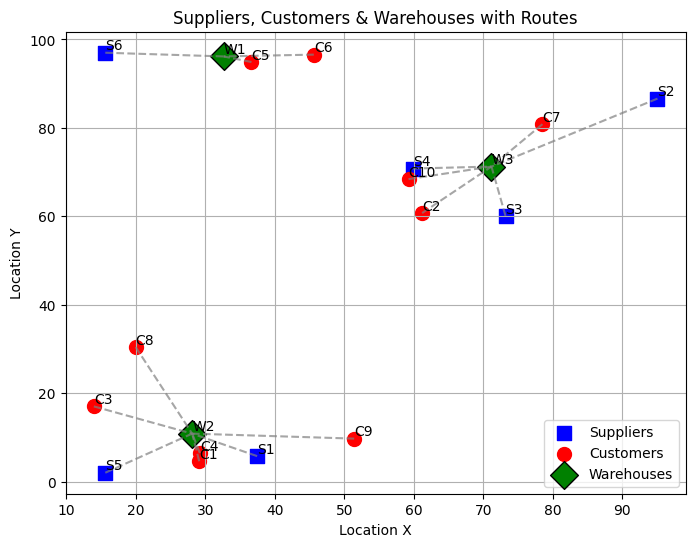

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load datasets
suppliers = pd.read_csv("suppliers.csv")
customers = pd.read_csv("customers.csv")
warehouses = pd.read_csv("warehouse.csv")
routes = pd.read_csv("routes.csv")

# Plot suppliers, customers, and warehouses
plt.figure(figsize=(8, 6))
plt.scatter(suppliers["Location_X"], suppliers["Location_Y"], color='blue', label="Suppliers", marker='s', s=100)
plt.scatter(customers["Location_X"], customers["Location_Y"], color='red', label="Customers", marker='o', s=100)
plt.scatter(warehouses["Location_X"], warehouses["Location_Y"], color='green', label="Warehouses", marker='D', s=200, edgecolors='black')

# Annotate points
for i, row in suppliers.iterrows():
    plt.text(row["Location_X"], row["Location_Y"], f"S{i+1}", fontsize=10, verticalalignment='bottom')

for i, row in customers.iterrows():
    plt.text(row["Location_X"], row["Location_Y"], f"C{i+1}", fontsize=10, verticalalignment='bottom')

for i, row in warehouses.iterrows():
    plt.text(row["Location_X"], row["Location_Y"], f"W{i+1}", fontsize=10, verticalalignment='bottom')

# Overlay routes as lines
for _, row in routes.iterrows():
    start = suppliers[suppliers["Supplier_ID"] == row["Start_Location"]]
    if start.empty:
        start = customers[customers["Customer_ID"] == row["Start_Location"]]

    end = warehouses[warehouses["Warehouse_ID"] == row["End_Location"]]

    if not start.empty and not end.empty:
        plt.plot([start["Location_X"].values[0], end["Location_X"].values[0]],
                 [start["Location_Y"].values[0], end["Location_Y"].values[0]],
                 'gray', linestyle="dashed", alpha=0.7)  # Dashed lines for visibility

# Plot customization
plt.xlabel("Location X")
plt.ylabel("Location Y")
plt.title("Suppliers, Customers & Warehouses with Routes")
plt.legend()
plt.grid(True)
plt.show()



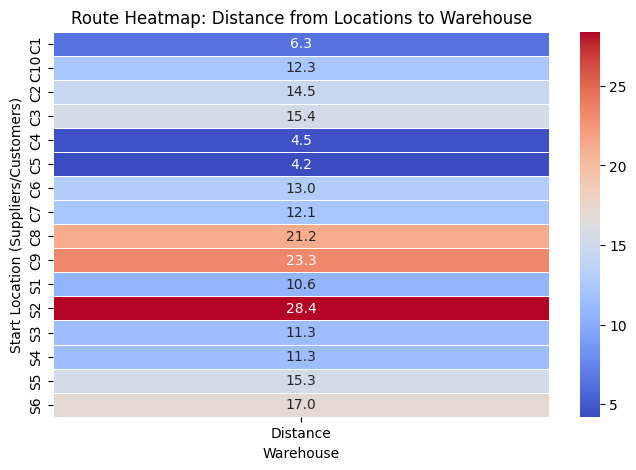

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset
routes = pd.read_csv("routes.csv")

# Ensure Distance column is numeric (convert if necessary)
routes["Distance"] = routes["Distance"].astype(str).str.extract(r"([\d\.]+)").astype(float)

# Create pivot table for heatmap
heatmap_data = routes.pivot_table(index="Start_Location", values="Distance", aggfunc="sum")

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5)
plt.title("Route Heatmap: Distance from Locations to Warehouse")
plt.xlabel("Warehouse")
plt.ylabel("Start Location (Suppliers/Customers)")
plt.show()


# Demand Forecasting

**Simulate Historical Demand Data**

In [ ]:
import numpy as np
import pandas as pd

# Parameters
num_customers = 10
time_steps = 50  # Historical time steps

# Simulate time-series demand data
np.random.seed(42)
demand_data = {
    f'C{i}': np.random.randint(10, 50, time_steps) + np.sin(np.linspace(0, 2 * np.pi, time_steps)) * 10
    for i in range(1, num_customers + 1)
}

# Convert to DataFrame
demand_df = pd.DataFrame(demand_data)
demand_df.index.name = 'Time_Step'

# Save to CSV
demand_df.to_csv('historical_demand.csv')
print("Historical demand data saved as 'historical_demand.csv'")

Historical demand data saved as 'historical_demand.csv'


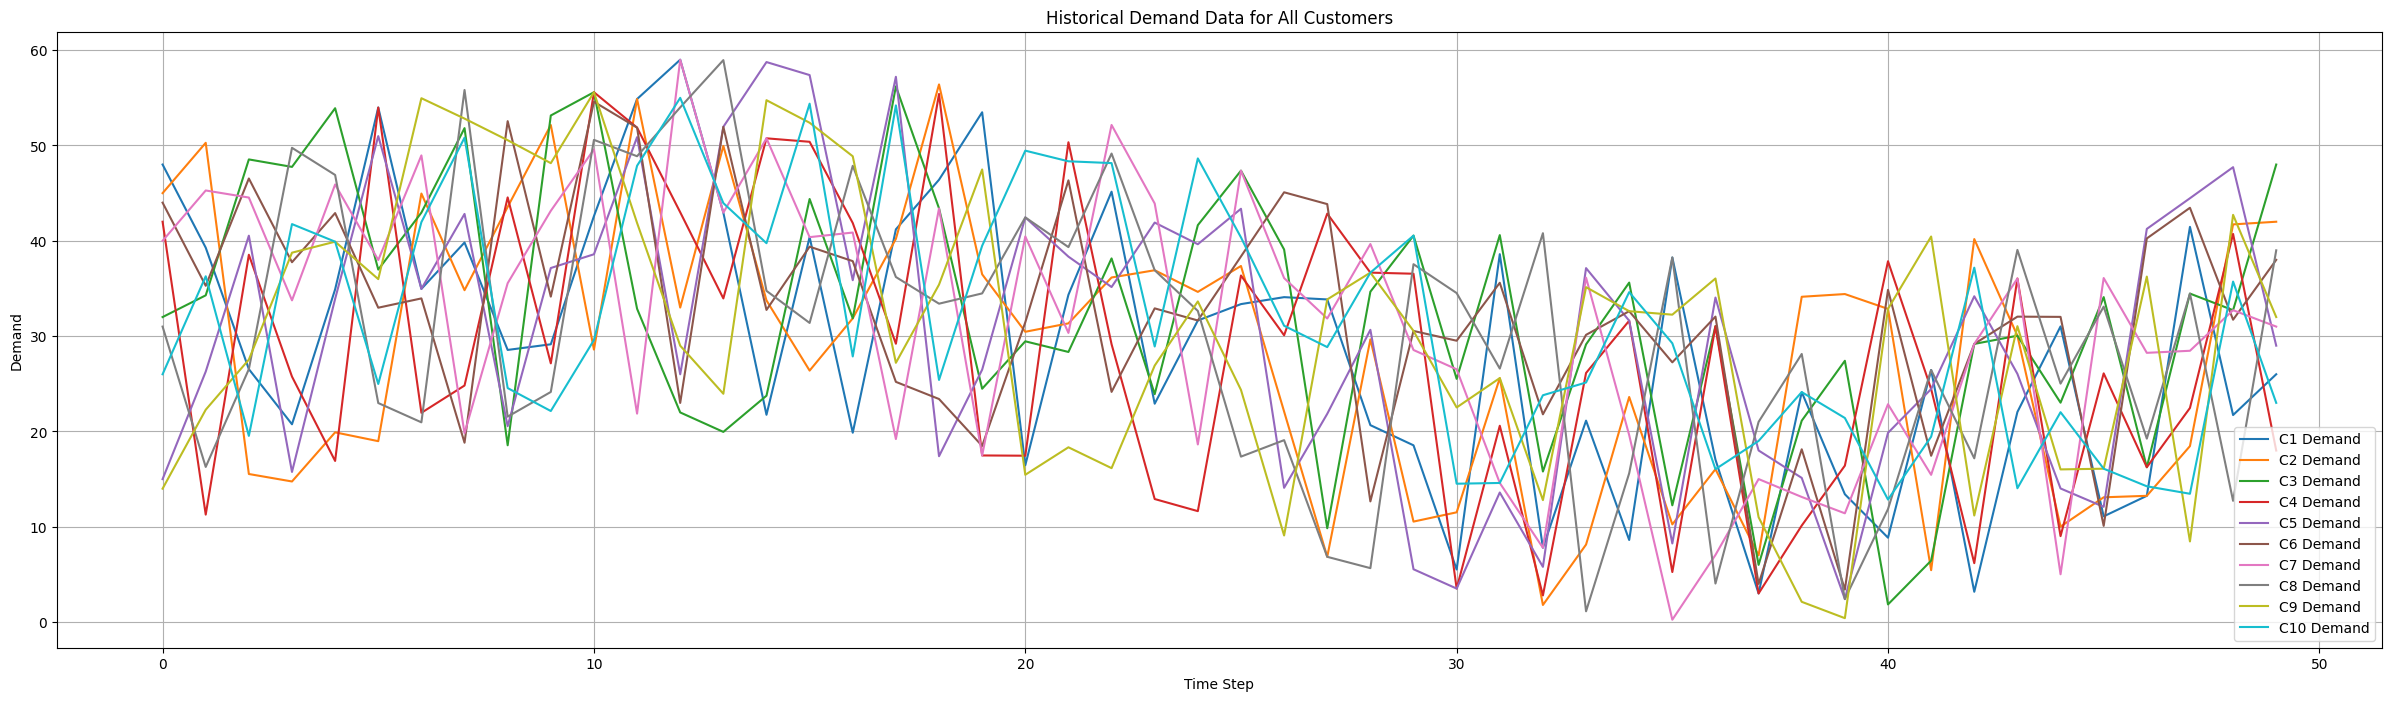

In [ ]:
import matplotlib.pyplot as plt

# Plot historical demand for all customers
plt.figure(figsize=(30, 8))

# Plot demand for each customer
for customer in demand_df.columns:
    plt.plot(demand_df.index, demand_df[customer], label=f'{customer} Demand')

# Adding labels and title
plt.xlabel("Time Step")
plt.ylabel("Demand")
plt.title("Historical Demand Data for All Customers")
plt.legend()
plt.grid(True)
plt.show()


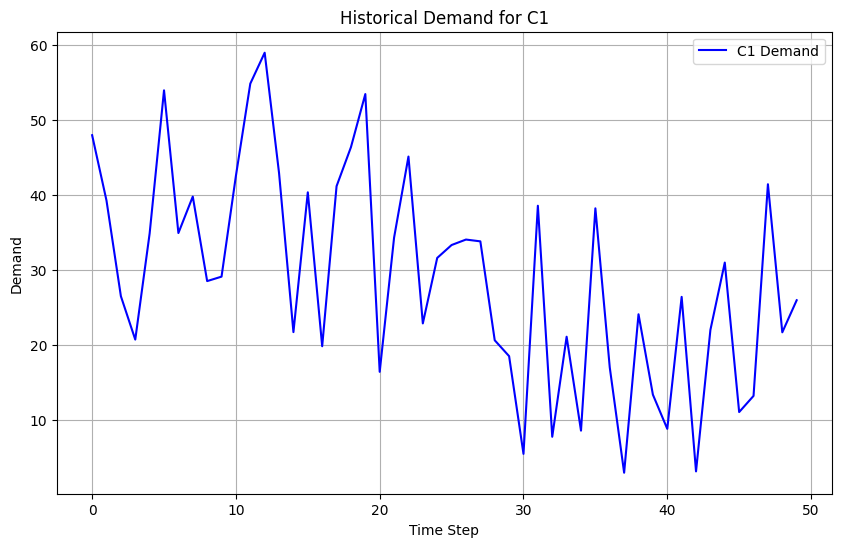

In [ ]:
import matplotlib.pyplot as plt

# Choose a single customer (e.g., 'C1')
customer = 'C1'

# Plot demand for the selected customer
plt.figure(figsize=(10, 6))
plt.plot(demand_df.index, demand_df[customer], label=f'{customer} Demand', color='blue')

# Adding labels and title
plt.xlabel("Time Step")
plt.ylabel("Demand")
plt.title(f"Historical Demand for {customer}")
plt.legend()
plt.grid(True)
plt.show()


**Prepare Data for LSTM**

In [ ]:
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np  # Import numpy for better performance

# Load data
data = pd.read_csv('historical_demand.csv', index_col='Time_Step')

# Normalize data
scaler = MinMaxScaler()

# Prepare sequences for all customers
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append((seq, label))
    return sequences

# Define sequence length
seq_length = 10

# Dictionary to hold sequences for each customer
all_sequences = {}

for customer_id in data.columns:
    # Normalize customer data
    customer_data = data[customer_id].values.reshape(-1, 1)
    scaled_data = scaler.fit_transform(customer_data)

    # Create sequences and labels for this customer
    sequences = create_sequences(scaled_data, seq_length)

    # Convert to tensors and store
    X_customer = torch.tensor(np.array([s[0] for s in sequences]), dtype=torch.float32)
    y_customer = torch.tensor(np.array([s[1] for s in sequences]), dtype=torch.float32)

    # Store in the dictionary
    all_sequences[customer_id] = (X_customer, y_customer)

# Print shapes for all customers
print("Shapes for all customers:")
for customer_id, (X_customer, y_customer) in all_sequences.items():
    print(f"Customer {customer_id}:")
    print(f"  Shape of input (X): {X_customer.shape}")
    print(f"  Shape of labels (y): {y_customer.shape}")


Shapes for all customers:
Customer C1:
  Shape of input (X): torch.Size([40, 10, 1])
  Shape of labels (y): torch.Size([40, 1])
Customer C2:
  Shape of input (X): torch.Size([40, 10, 1])
  Shape of labels (y): torch.Size([40, 1])
Customer C3:
  Shape of input (X): torch.Size([40, 10, 1])
  Shape of labels (y): torch.Size([40, 1])
Customer C4:
  Shape of input (X): torch.Size([40, 10, 1])
  Shape of labels (y): torch.Size([40, 1])
Customer C5:
  Shape of input (X): torch.Size([40, 10, 1])
  Shape of labels (y): torch.Size([40, 1])
Customer C6:
  Shape of input (X): torch.Size([40, 10, 1])
  Shape of labels (y): torch.Size([40, 1])
Customer C7:
  Shape of input (X): torch.Size([40, 10, 1])
  Shape of labels (y): torch.Size([40, 1])
Customer C8:
  Shape of input (X): torch.Size([40, 10, 1])
  Shape of labels (y): torch.Size([40, 1])
Customer C9:
  Shape of input (X): torch.Size([40, 10, 1])
  Shape of labels (y): torch.Size([40, 1])
Customer C10:
  Shape of input (X): torch.Size([40, 10, 

**Build and Train the LSTM Model**

In [ ]:
import torch.nn as nn

# Define LSTM Model
class DemandLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(DemandLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last output for prediction
        return out

# Model, loss function, optimizer
model = DemandLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 200  # or any other number of epochs you want to train for

# Concatenate data for all customers into one dataset
all_X = torch.cat([X for X, _ in all_sequences.values()], dim=0)
all_y = torch.cat([y for _, y in all_sequences.values()], dim=0)

# Training the model on all customers' data
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(all_X)
    loss = criterion(outputs, all_y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

print("Training completed on all customers' data!")




Epoch [10/200], Loss: 0.1330
Epoch [20/200], Loss: 0.0738
Epoch [30/200], Loss: 0.0698
Epoch [40/200], Loss: 0.0679
Epoch [50/200], Loss: 0.0661
Epoch [60/200], Loss: 0.0634
Epoch [70/200], Loss: 0.0571
Epoch [80/200], Loss: 0.0564
Epoch [90/200], Loss: 0.0558
Epoch [100/200], Loss: 0.0555
Epoch [110/200], Loss: 0.0553
Epoch [120/200], Loss: 0.0552
Epoch [130/200], Loss: 0.0551
Epoch [140/200], Loss: 0.0550
Epoch [150/200], Loss: 0.0550
Epoch [160/200], Loss: 0.0549
Epoch [170/200], Loss: 0.0549
Epoch [180/200], Loss: 0.0548
Epoch [190/200], Loss: 0.0547
Epoch [200/200], Loss: 0.0547
Training completed on all customers' data!


**Evaluate and Visualize Predictions**

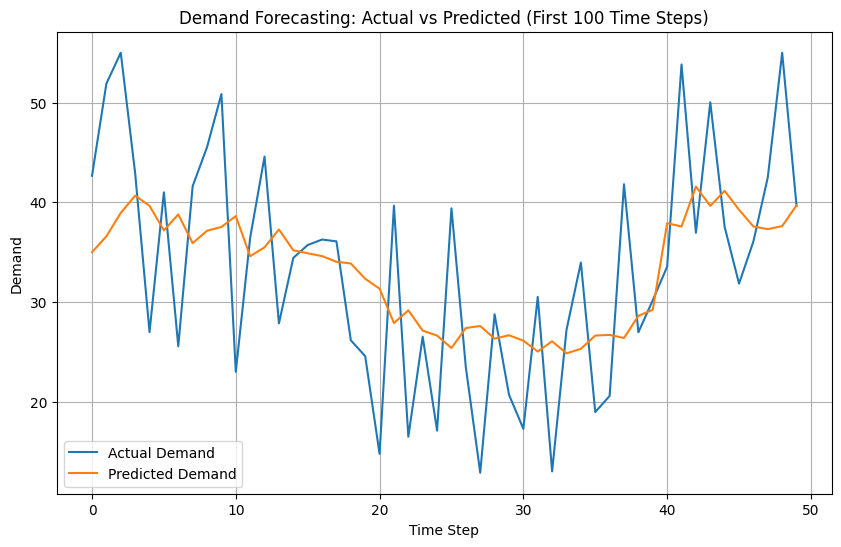

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model
model.eval()
predictions = model(all_X).detach().numpy()
actual = all_y.numpy()

# Define the number of time steps to plot
num_time_steps = 50  # Change this number to adjust the range

# Plot actual vs predicted for fewer time steps
plt.figure(figsize=(10, 6))
plt.plot(range(num_time_steps), scaler.inverse_transform(actual[:num_time_steps]), label="Actual Demand")
plt.plot(range(num_time_steps), scaler.inverse_transform(predictions[:num_time_steps]), label="Predicted Demand")

# Add labels and title
plt.xlabel("Time Step")  # X-axis label
plt.ylabel("Demand")     # Y-axis label
plt.legend()
plt.title("Demand Forecasting: Actual vs Predicted (First 100 Time Steps)")
plt.grid(True)
plt.show()


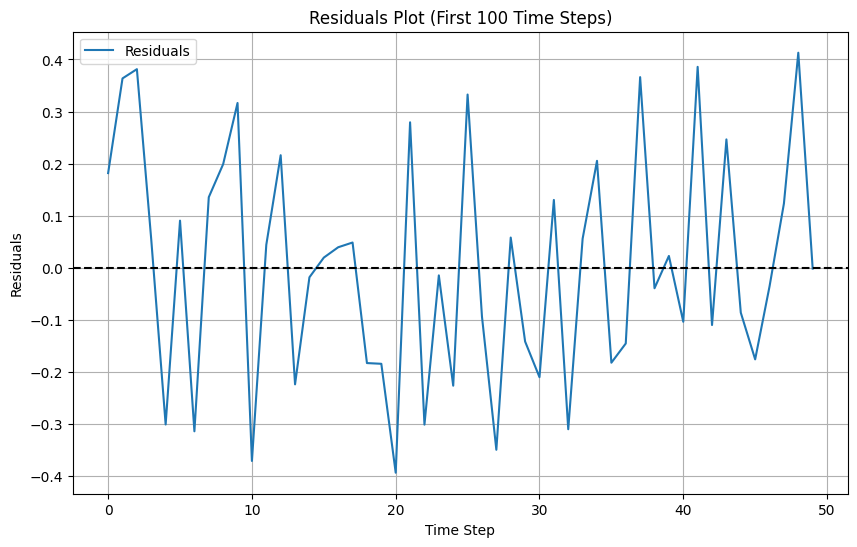

In [ ]:
residuals = actual - predictions

# Define the number of time steps to plot
num_time_steps = 50  # Change this number to adjust the range

# Plot residuals for fewer time steps
plt.figure(figsize=(10, 6))
plt.plot(range(num_time_steps), residuals[:num_time_steps], label="Residuals")
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Time Step")
plt.ylabel("Residuals")
plt.title("Residuals Plot (First 100 Time Steps)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(actual, predictions)
print(f"Mean Squared Error (MSE): {mse}")


Mean Squared Error (MSE): 0.05455336719751358


In [ ]:
# Set the new sequence length
seq_length = 20

# Set model to evaluation mode
model.eval()

# Prepare dictionary to store predictions
future_predictions = {}

# Loop through each customer in the dataset
for customer_id in data.columns:
    # Get the last `seq_length` time steps for the customer
    last_sequence = data[customer_id].values[-seq_length:].reshape(1, seq_length, 1)

    # Normalize the sequence using the trained scaler
    scaled_sequence = scaler.transform(last_sequence.reshape(-1, 1)).reshape(1, seq_length, 1)

    # Convert to tensor
    input_tensor = torch.tensor(scaled_sequence, dtype=torch.float32)

    # Predict demand
    with torch.no_grad():
        predicted_scaled = model(input_tensor).item()  # Get scalar prediction

    # Convert back to actual demand value
    predicted_demand = scaler.inverse_transform(np.array(predicted_scaled).reshape(-1, 1))[0, 0]

    # Store the prediction
    future_predictions[customer_id] = predicted_demand

# Print the predicted demand for each customer
print("\nPredicted Future Demand for Each Customer based on last 5 time steps:")
for customer, prediction in future_predictions.items():
    print(f"{customer}: {prediction:.2f}")



Predicted Future Demand for Each Customer based on last 5 time steps:
C1: 27.02
C2: 28.33
C3: 33.08
C4: 26.95
C5: 34.47
C6: 34.02
C7: 30.73
C8: 29.34
C9: 28.72
C10: 25.08


In [ ]:
# Ensure only customer-related routes are selected
customer_routes = routes[routes['Start_Location'].isin(customers['Customer_ID'])]  # Filter only customer start points

# Add customer predictions to the `customers` DataFrame
customers['Predicted_Demand'] = customers['Customer_ID'].map(future_predictions)

# Assign each customer to a warehouse based on the nearest warehouse (filtered routes)
def assign_warehouse(customer_id):
    match = customer_routes[customer_routes['Start_Location'] == customer_id]['End_Location']
    return match.iloc[0] if not match.empty else None  # Return first match or None if not found

customers['Assigned_Warehouse'] = customers['Customer_ID'].apply(assign_warehouse)

# Group by warehouse and sum the predicted demand for customers in each warehouse
warehouse_demand = customers.groupby('Assigned_Warehouse', as_index=False)['Predicted_Demand'].sum()

# Merge with warehouses DataFrame to ensure all warehouses are included
warehouses = warehouses.merge(warehouse_demand, left_on='Warehouse_ID', right_on='Assigned_Warehouse', how='left')

# Fill NaN values with 0 in case some warehouses have no demand
warehouses['Predicted_Demand'] = warehouses['Predicted_Demand'].fillna(0).astype(int)

# Drop 'Assigned_Warehouse' column (optional)
warehouses.drop(columns=['Assigned_Warehouse'], inplace=True)

# Display the updated warehouses DataFrame
print("\nUpdated Warehouse Dataset with Predicted Demand:")
print(warehouses)

# Save the updated warehouses DataFrame to the warehouse.csv file
warehouses.to_csv('warehouse.csv', index=False)



Updated Warehouse Dataset with Predicted Demand:
  Warehouse_ID  Location_X  Location_Y  Capacity  Predicted_Demand
0           W1       32.62       96.15       500                68
1           W2       28.10       10.90       500               145
2           W3       71.18       71.26       500                84


# Route Optimization

In [ ]:
!pip install ortools
!pip install protobuf==4.25.5



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 28.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.26.1
    Uninstalling protobuf-5.26.1:
      Successfully uninstalled protobuf-5.26.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ortools 9.11.4210 requ

**Routing**

Enter number of trucks for W1: 2
Enter capacities for 2 trucks (comma-separated) for W1: 60,70
Enter number of trucks for W2: 2
Enter capacities for 2 trucks (comma-separated) for W2: 70,80
Enter number of trucks for W3: 2
Enter capacities for 2 trucks (comma-separated) for W3: 80,90

✅ Optimized Routes for Warehouse W1:

🚛 **Truck 1** (Capacity: 60)
   📍 Route: C6
   📏 Total Distance: 26 units
   📦 Load Delivered: 45 units

🚛 **Truck 2** (Capacity: 70)
   📍 Route: C5
   📏 Total Distance: 8 units
   📦 Load Delivered: 26 units

📊 **Total Distance for W1: 34 units**


✅ Optimized Routes for Warehouse W2:

🚛 **Truck 1** (Capacity: 70)
   📍 Route: C8 → C3
   📏 Total Distance: 50 units
   📦 Load Delivered: 57 units

🚛 **Truck 2** (Capacity: 80)
   📍 Route: C4 → C1 → C9
   📏 Total Distance: 50 units
   📦 Load Delivered: 50 units

📊 **Total Distance for W2: 100 units**


✅ Optimized Routes for Warehouse W3:

🚛 **Truck 1** (Capacity: 80)
   📍 Route: 
   📏 Total Distance: 0 units
   📦 Load Deli

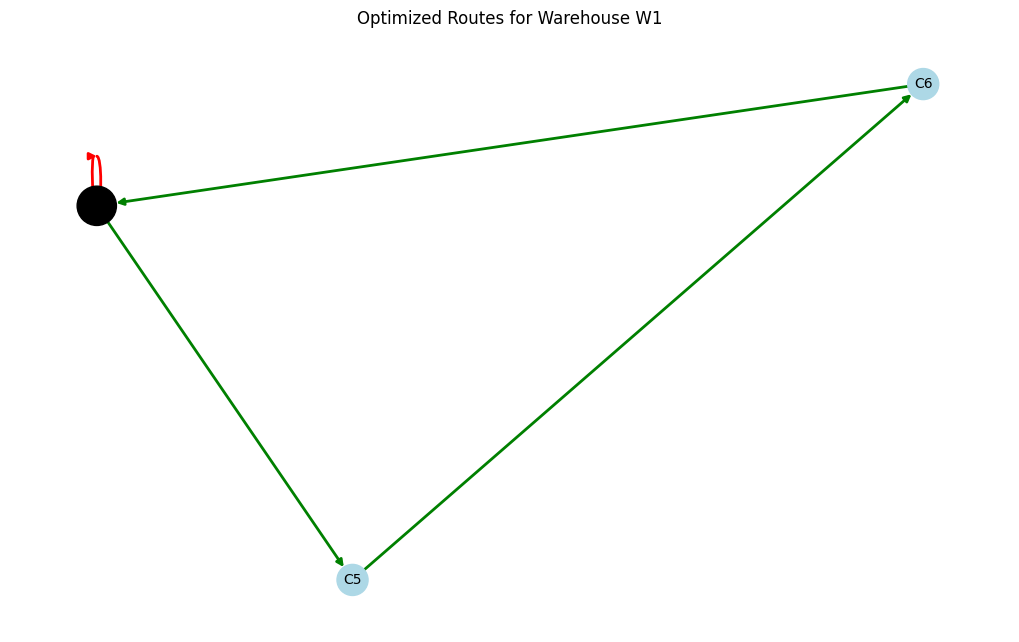

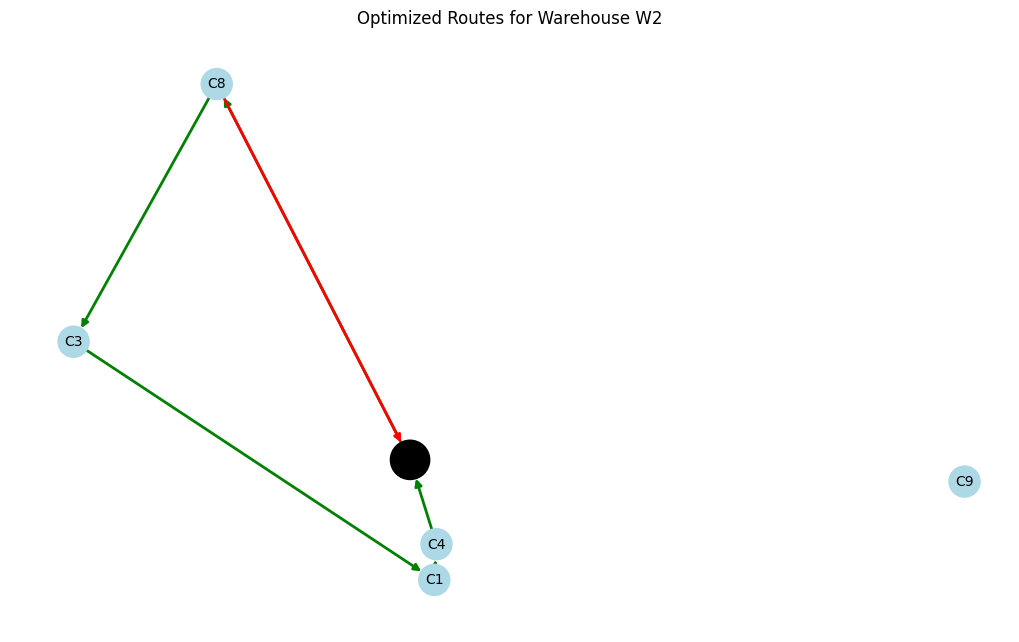

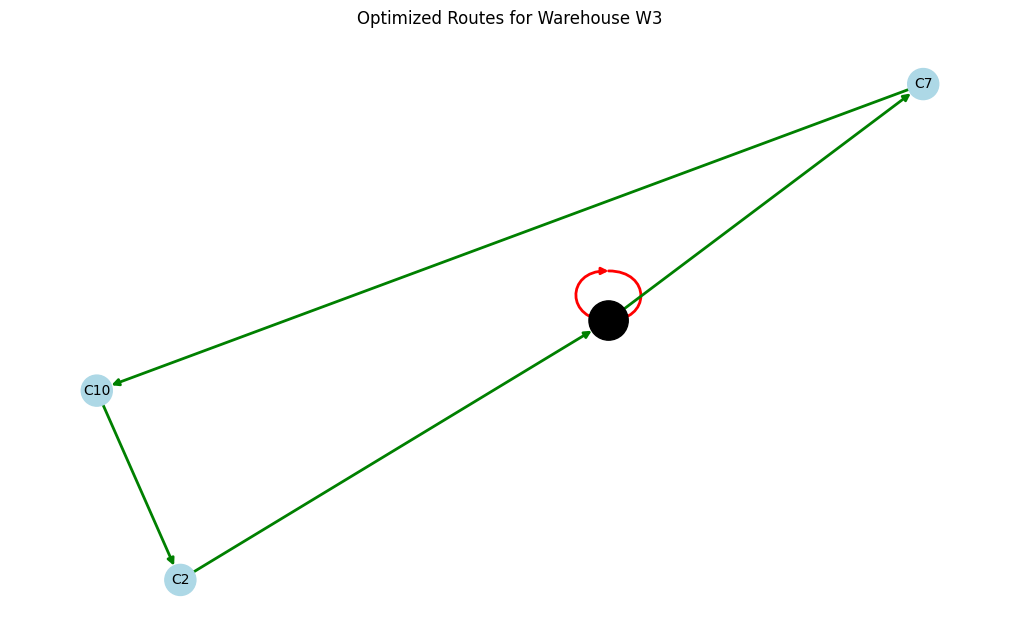

In [ ]:
import numpy as np
import pandas as pd
from ortools.constraint_solver import routing_enums_pb2, pywrapcp
from scipy.spatial.distance import cdist  # Faster distance computation

# Load datasets
customers = pd.read_csv("customers.csv")
warehouses = pd.read_csv("warehouse.csv")
routes = pd.read_csv("routes.csv")

# User input for number of trucks and capacities per warehouse
warehouse_trucks = {}

for _, row in warehouses.iterrows():
    warehouse_id = row["Warehouse_ID"]

    while True:
        try:
            num_trucks = int(input(f"Enter number of trucks for {warehouse_id}: "))
            capacities = list(map(int, input(f"Enter capacities for {num_trucks} trucks (comma-separated) for {warehouse_id}: ").split(',')))

            if len(capacities) != num_trucks:
                raise ValueError("Number of capacities must match number of trucks.")

            warehouse_trucks[warehouse_id] = capacities
            break  # Exit loop if input is valid
        except ValueError as e:
            print(f"Invalid input: {e}. Please try again.")

# Assign customers to warehouses
customer_assignments = {w: [] for w in warehouses["Warehouse_ID"]}

for _, row in routes.iterrows():
    if row["End_Location"] in customer_assignments:
        customer_assignments[row["End_Location"]].append(row["Start_Location"])

# Process each warehouse separately
for warehouse_id, capacities in warehouse_trucks.items():
    assigned_customers = customers[customers["Customer_ID"].isin(customer_assignments.get(warehouse_id, []))]

    if assigned_customers.empty:
        print(f"\n⚠️ No customers assigned to {warehouse_id}, skipping...\n")
        continue

    num_customers = len(assigned_customers)
    num_vehicles = len(capacities)
    customer_demands = assigned_customers["Demand"].values.tolist()

    # Compute distance matrix using scipy (faster)
    warehouse_location = warehouses.loc[warehouses["Warehouse_ID"] == warehouse_id, ["Location_X", "Location_Y"]].values[0]
    locations = np.vstack([assigned_customers[["Location_X", "Location_Y"]].values, warehouse_location])
    distance_matrix = cdist(locations, locations).round(2)

    # OR-Tools setup
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), num_vehicles, len(distance_matrix) - 1)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(distance_matrix[from_node][to_node])

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return customer_demands[from_node] if from_node < num_customers else 0

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # No slack
        capacities,
        True,
        "Capacity"
    )

    # Solve the routing problem
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        print(f"\n✅ Optimized Routes for Warehouse {warehouse_id}:")
        total_distance = 0

        for vehicle_id in range(num_vehicles):
            index = routing.Start(vehicle_id)
            route_distance = 0
            route_load = 0
            route_customers = []  # Track sequence of customers per truck

            print(f"\n🚛 **Truck {vehicle_id + 1}** (Capacity: {capacities[vehicle_id]})")

            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                if node_index < num_customers:
                    route_customers.append(assigned_customers.iloc[node_index]['Customer_ID'])
                    route_load += customer_demands[node_index]

                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)

            # Display the route
            print(f"   📍 Route: {' → '.join(map(str, route_customers))}")
            print(f"   📏 Total Distance: {route_distance} units")
            print(f"   📦 Load Delivered: {route_load} units")

            total_distance += route_distance

        print(f"\n📊 **Total Distance for {warehouse_id}: {total_distance} units**\n")
    else:
        print(f"\n❌ No solution found for Warehouse {warehouse_id}!\n")

import matplotlib.pyplot as plt
import networkx as nx

def plot_routes_per_warehouse(warehouse_id, assigned_customers, solution, routing, manager, num_customers, num_vehicles):
    plt.figure(figsize=(10, 6))
    G = nx.DiGraph()

    # Get warehouse coordinates
    warehouse_location = warehouses.loc[warehouses["Warehouse_ID"] == warehouse_id, ["Location_X", "Location_Y"]].values[0]

    # Customer locations
    customer_coords = assigned_customers[["Location_X", "Location_Y"]].values
    customer_ids = assigned_customers["Customer_ID"].tolist()

    # Add nodes (warehouse + customers)
    G.add_node(f"W{warehouse_id}", pos=tuple(warehouse_location), color="black", size=800)
    for i, customer_id in enumerate(customer_ids):
        G.add_node(customer_id, pos=tuple(customer_coords[i]), color="lightblue", size=500)

    # Define color palette for trucks
    colors = ["r", "g", "b", "c", "m", "y", "orange", "purple", "pink", "brown"]

    for vehicle_id in range(num_vehicles):
        index = routing.Start(vehicle_id)
        prev_node = f"W{warehouse_id}"
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            if node_index < num_customers:
                customer_id = assigned_customers.iloc[node_index]["Customer_ID"]
                G.add_edge(prev_node, customer_id, color=colors[vehicle_id % len(colors)], weight=2)
                prev_node = customer_id
            index = solution.Value(routing.NextVar(index))

        # Connect last customer back to warehouse
        G.add_edge(prev_node, f"W{warehouse_id}", color=colors[vehicle_id % len(colors)], weight=2)

    # Get node positions and colors
    pos = nx.get_node_attributes(G, 'pos')
    node_colors = [G.nodes[n].get('color', "lightblue") for n in G.nodes()]
    node_sizes = [G.nodes[n].get('size', 500) for n in G.nodes()]
    edges = G.edges()
    edge_colors = [G[u][v]['color'] for u, v in edges]

    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, edge_color=edge_colors, width=2, font_size=10)

    plt.title(f"Optimized Routes for Warehouse {warehouse_id}")
    plt.show()

# Store solutions for each warehouse to visualize later
solutions = {}

# Solve for each warehouse and store results
for warehouse_id, capacities in warehouse_trucks.items():
    assigned_customers = customers[customers["Customer_ID"].isin(customer_assignments.get(warehouse_id, []))]

    if assigned_customers.empty:
        continue  # Skip if no customers assigned

    num_customers = len(assigned_customers)
    num_vehicles = len(capacities)

    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        solutions[warehouse_id] = (solution, routing, manager, num_customers, assigned_customers)

# Generate separate plots for each warehouse
for warehouse_id, (solution, routing, manager, num_customers, assigned_customers) in solutions.items():
    plot_routes_per_warehouse(warehouse_id, assigned_customers, solution, routing, manager, num_customers, len(warehouse_trucks[warehouse_id]))



In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment

# Load datasets
suppliers = pd.read_csv('suppliers.csv')
warehouses = pd.read_csv('warehouse.csv')
routes = pd.read_csv('routes.csv')

# Initialize demand fulfillment tracker
demand_fulfillment = {w: 0 for w in warehouses['Warehouse_ID']}
supplier_capacity = {s: c for s, c in zip(suppliers['Supplier_ID'], suppliers['Supplying_Capacity'])}

# Create cost matrix based on distances
cost_matrix = np.zeros((len(suppliers), len(warehouses)))
for i, (s_x, s_y) in enumerate(zip(suppliers['Location_X'], suppliers['Location_Y'])):
    for j, (w_x, w_y) in enumerate(zip(warehouses['Location_X'], warehouses['Location_Y'])):
        cost_matrix[i, j] = np.linalg.norm([s_x - w_x, s_y - w_y])

# Use predefined supplier assignments from routes.csv
supplier_assignments = routes.groupby('End_Location')['Start_Location'].apply(list).to_dict()

# Allocate goods based on capacity and demand
allocation = []
total_distance = 0  # Variable to track total distance traveled

for warehouse, suppliers_list in supplier_assignments.items():
    demand = warehouses.loc[warehouses['Warehouse_ID'] == warehouse, 'Predicted_Demand'].values[0]
    fulfilled = 0

    for supplier in suppliers_list:
        if supplier in supplier_capacity and supplier_capacity[supplier] > 0:
            allocation_amount = min(supplier_capacity[supplier], demand - fulfilled)
            fulfilled += allocation_amount
            supplier_capacity[supplier] -= allocation_amount

            # Calculate distance for the allocation
            s_x, s_y = suppliers.loc[suppliers['Supplier_ID'] == supplier, ['Location_X', 'Location_Y']].values[0]
            w_x, w_y = warehouses.loc[warehouses['Warehouse_ID'] == warehouse, ['Location_X', 'Location_Y']].values[0]
            distance = np.linalg.norm([s_x - w_x, s_y - w_y])

            # Add the allocation record along with distance
            allocation.append({'Supplier': supplier, 'Warehouse': warehouse, 'Allocated': allocation_amount, 'Distance': distance})

            # Update total distance traveled
            total_distance += distance * allocation_amount  # Multiply distance by allocation amount to account for quantity

        if fulfilled >= demand:
            break  # Stop if demand is fully met

    demand_fulfillment[warehouse] = fulfilled

# Handle unfulfilled demand by assigning additional suppliers (from any warehouse)
for warehouse, fulfilled in demand_fulfillment.items():
    remaining_demand = warehouses.loc[warehouses['Warehouse_ID'] == warehouse, 'Predicted_Demand'].values[0] - fulfilled
    if remaining_demand > 0:
        for supplier in supplier_capacity:
            if supplier_capacity[supplier] > 0:
                allocation_amount = min(supplier_capacity[supplier], remaining_demand)
                demand_fulfillment[warehouse] += allocation_amount
                supplier_capacity[supplier] -= allocation_amount
                remaining_demand -= allocation_amount

                # Calculate distance for the allocation
                s_x, s_y = suppliers.loc[suppliers['Supplier_ID'] == supplier, ['Location_X', 'Location_Y']].values[0]
                w_x, w_y = warehouses.loc[warehouses['Warehouse_ID'] == warehouse, ['Location_X', 'Location_Y']].values[0]
                distance = np.linalg.norm([s_x - w_x, s_y - w_y])

                # Add the allocation record along with distance
                allocation.append({'Supplier': supplier, 'Warehouse': warehouse, 'Allocated': allocation_amount, 'Distance': distance})

                # Update total distance traveled
                total_distance += distance * allocation_amount  # Multiply distance by allocation amount to account for quantity

                if remaining_demand == 0:
                    break

# Save allocation results
allocation_df = pd.DataFrame(allocation)
allocation_df.to_csv('allocation_results.csv', index=False)

# Print allocation results
print("Allocation Results:")
print(allocation_df)

# Print summary of fulfilled demand
print("\nFinal Demand Fulfillment Status:")
for warehouse, fulfilled in demand_fulfillment.items():
    total_demand = warehouses.loc[warehouses['Warehouse_ID'] == warehouse, 'Predicted_Demand'].values[0]
    print(f"Warehouse {warehouse}: Fulfilled {fulfilled}/{total_demand}")



print("\nAllocation completed and saved to allocation_results.csv")


Allocation Results:
  Supplier Warehouse  Allocated   Distance
0       S6        W1         66  17.040716
1       S1        W2         87  10.645685
2       S5        W2         55  15.309984
3       S2        W3         83  28.401790

Final Demand Fulfillment Status:
Warehouse W1: Fulfilled 66/66
Warehouse W2: Fulfilled 142/142
Warehouse W3: Fulfilled 83/83

Allocation completed and saved to allocation_results.csv


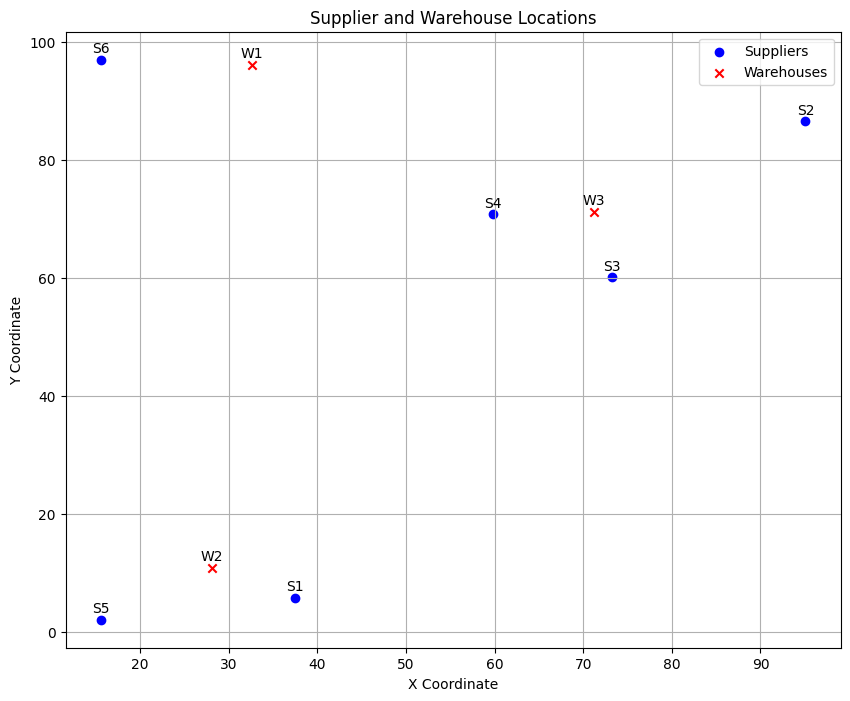

In [ ]:
import matplotlib.pyplot as plt

# Plot supplier and warehouse locations
plt.figure(figsize=(10, 8))
plt.scatter(suppliers['Location_X'], suppliers['Location_Y'], c='blue', label='Suppliers', marker='o')
plt.scatter(warehouses['Location_X'], warehouses['Location_Y'], c='red', label='Warehouses', marker='x')

# Add labels and title
for i, txt in enumerate(suppliers['Supplier_ID']):
    plt.annotate(txt, (suppliers['Location_X'][i], suppliers['Location_Y'][i]), textcoords="offset points", xytext=(0, 5), ha='center')

for i, txt in enumerate(warehouses['Warehouse_ID']):
    plt.annotate(txt, (warehouses['Location_X'][i], warehouses['Location_Y'][i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Supplier and Warehouse Locations')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()


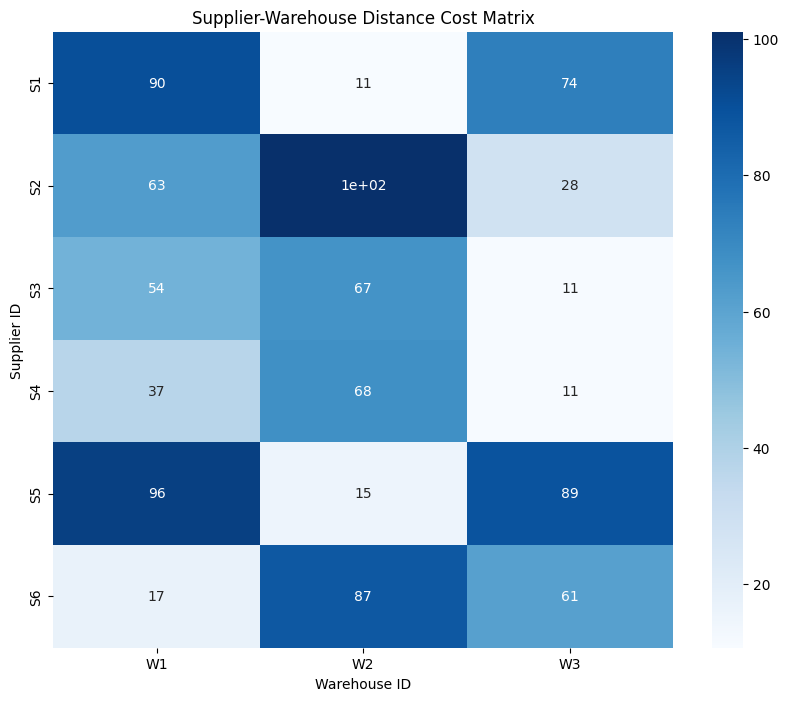

In [ ]:
import seaborn as sns

# Create a heatmap for the cost matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cost_matrix, annot=True, cmap='Blues', xticklabels=warehouses['Warehouse_ID'], yticklabels=suppliers['Supplier_ID'])
plt.title('Supplier-Warehouse Distance Cost Matrix')
plt.xlabel('Warehouse ID')
plt.ylabel('Supplier ID')
plt.show()


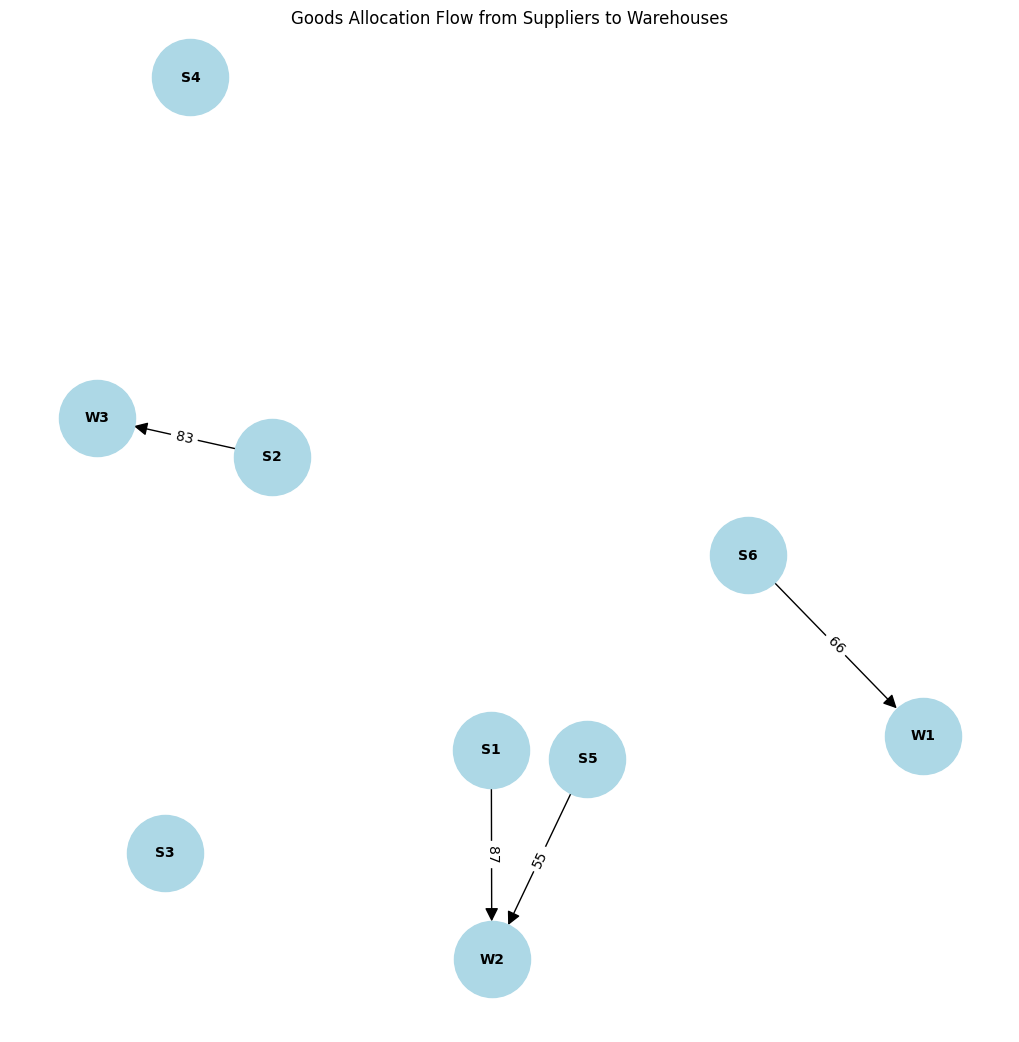

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph for allocations
G = nx.DiGraph()

# Add nodes (suppliers and warehouses)
for supplier in suppliers['Supplier_ID']:
    G.add_node(supplier, type='supplier')
for warehouse in warehouses['Warehouse_ID']:
    G.add_node(warehouse, type='warehouse')

# Add edges based on allocation
for alloc in allocation:
    G.add_edge(alloc['Supplier'], alloc['Warehouse'], weight=alloc['Allocated'])

# Increase k to spread nodes out more in spring layout
pos = nx.spring_layout(G, k=2, seed=42)  # Increase k to spread out nodes more

# Increase the figure size and adjust node size
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, node_color='lightblue', font_size=10, node_size=3000, font_weight='bold', arrowsize=20)

# Add edge labels for allocation amounts
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title('Goods Allocation Flow from Suppliers to Warehouses')
plt.show()


# Dock Allocation with Reinforcement Learning

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class DockAllocationEnv:
    def __init__(self, num_in_docks, num_out_docks, num_vehicles, max_time=100):
        self.num_in_docks = num_in_docks
        self.num_out_docks = num_out_docks
        self.num_docks = num_in_docks + num_out_docks
        self.num_vehicles = num_vehicles
        self.in_docks = None
        self.out_docks = None
        self.vehicles = None
        self.time_step = 0
        self.max_time = max_time  # Maximum simulation time
        self.done = False

    def reset(self):
        self.in_docks = np.zeros(self.num_in_docks)  # Reset inbound dock usage times to idle
        self.out_docks = np.zeros(self.num_out_docks)  # Reset outbound dock usage times to idle
        self.vehicles = [{"id": i, "demand": 1} for i in range(self.num_vehicles)]  # Each vehicle starts with demand=1
        self.time_step = 0
        self.done = False
        return self._get_state()

    def step(self, action_in, action_out):
        reward = 0

        # Allocate inbound vehicle to inbound dock if possible
        if self.vehicles and self.in_docks[action_in] == 0:
            self.in_docks[action_in] = random.randint(1, 5)  # Simulate busy time for inbound dock
            self.vehicles.pop(0)  # Vehicle's demand is fulfilled for inbound
            reward += 1  # Reward for successful inbound allocation

        # Allocate outbound vehicle to outbound dock if possible
        if self.vehicles and self.out_docks[action_out] == 0:
            self.out_docks[action_out] = random.randint(1, 5)  # Simulate busy time for outbound dock
            self.vehicles.pop(0)  # Vehicle's demand is fulfilled for outbound
            reward += 1  # Reward for successful outbound allocation

        # Update dock busy times
        self.in_docks = np.maximum(0, self.in_docks - 1)
        self.out_docks = np.maximum(0, self.out_docks - 1)

        # Increment time step
        self.time_step += 1

        # Check if the episode is done
        self.done = (len(self.vehicles) == 0 and np.all(self.in_docks == 0) and np.all(self.out_docks == 0)) or self.time_step >= self.max_time

        return self._get_state(), reward, self.done, {}

    def _get_state(self):
        # State includes inbound dock times, outbound dock times, remaining vehicles, and time step
        return np.concatenate((self.in_docks, self.out_docks, [len(self.vehicles), self.time_step]))


# Define the Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action_in, action_out, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action_in, action_out, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, action_ins, action_outs, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(action_ins),
            np.array(action_outs),
            np.array(rewards),
            np.array(next_states),
            np.array(dones),
        )

    def __len__(self):
        return len(self.buffer)


# Define the Q-Network
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


# Training parameters
num_in_docks = 3
num_out_docks = 3
state_size = num_in_docks + num_out_docks + 2  # Number of docks + remaining vehicles + time step
action_size_in = num_in_docks  # Number of inbound docks
action_size_out = num_out_docks  # Number of outbound docks
batch_size = 32
gamma = 0.99
lr = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 2000

# Environment, Model, Optimizer, and Replay Buffer
env = DockAllocationEnv(num_in_docks, num_out_docks, num_vehicles=10)
q_network = QNetwork(state_size, num_in_docks + num_out_docks).to(torch.device("cpu"))
optimizer = optim.Adam(q_network.parameters(), lr=lr)
memory = ReplayBuffer(10000)

import matplotlib.pyplot as plt

# Initialize lists to store rewards and loss for visualization
reward_history = []
loss_history = []

# Training Loop
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    running_loss = 0

    while not env.done:
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action_in = random.randint(0, action_size_in - 1)
            action_out = random.randint(0, action_size_out - 1)
        else:
            with torch.no_grad():
                q_values = q_network(torch.FloatTensor(state))

                # Split q_values into inbound and outbound allocations
                action_in = torch.argmax(q_values[:num_in_docks]).item()
                action_out = torch.argmax(q_values[num_in_docks:]).item()

        # Step the environment
        next_state, reward, done, _ = env.step(action_in, action_out)
        memory.push(state, action_in, action_out, reward, next_state, done)
        state = next_state
        total_reward += reward

        # Train the agent
        if len(memory) >= batch_size:
            states, action_ins, action_outs, rewards, next_states, dones = memory.sample(batch_size)

            states = torch.FloatTensor(states)
            action_ins = torch.LongTensor(action_ins)
            action_outs = torch.LongTensor(action_outs)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones)

            q_values = q_network(states)
            next_q_values = q_network(next_states)

            # Calculate the target Q-values for inbound and outbound actions
            target_q_values_in = rewards + (1 - dones) * gamma * torch.max(next_q_values[:, :num_in_docks], dim=1)[0]
            target_q_values_out = rewards + (1 - dones) * gamma * torch.max(next_q_values[:, num_in_docks:], dim=1)[0]

            # Get the predicted Q-values for inbound and outbound actions
            q_values_in = q_values.gather(1, action_ins.unsqueeze(1)).squeeze(1)
            q_values_out = q_values.gather(1, (action_outs + num_in_docks).unsqueeze(1)).squeeze(1)

            # Calculate the loss for inbound and outbound separately
            loss_in = nn.MSELoss()(q_values_in, target_q_values_in.detach())
            loss_out = nn.MSELoss()(q_values_out, target_q_values_out.detach())

            # Combine the losses
            loss = loss_in + loss_out

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

    # Store rewards and loss for plotting
    reward_history.append(total_reward)
    loss_history.append(running_loss / 100)

    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Avg Loss: {running_loss / 100}")
        running_loss = 0

print("Training completed!")

# Plot the rewards and loss over episodes
# plt.figure(figsize=(12, 6))

# # Plot total rewards
# # plt.subplot(1, 2, 1)
# # plt.plot(reward_history, label="Total Reward", color="blue")
# # plt.title("Total Reward over Episodes")
# # plt.xlabel("Episode")
# # plt.ylabel("Total Reward")
# # plt.legend()


# plt.tight_layout()
# plt.show()


Episode 100/2000, Total Reward: 10, Avg Loss: 0.0009582579112611711
Episode 200/2000, Total Reward: 10, Avg Loss: 0.0009229719312861561
Episode 300/2000, Total Reward: 10, Avg Loss: 0.0003638271894305944
Episode 400/2000, Total Reward: 10, Avg Loss: 0.00035773150390014055
Episode 500/2000, Total Reward: 10, Avg Loss: 0.0003531362907961011
Episode 600/2000, Total Reward: 10, Avg Loss: 0.0007941812952049076
Episode 700/2000, Total Reward: 10, Avg Loss: 0.000530376749811694
Episode 800/2000, Total Reward: 10, Avg Loss: 0.00021179297007620335
Episode 900/2000, Total Reward: 10, Avg Loss: 0.0002328226191457361
Episode 1000/2000, Total Reward: 10, Avg Loss: 0.0003773004491813481
Episode 1100/2000, Total Reward: 10, Avg Loss: 0.00028606777195818724
Episode 1200/2000, Total Reward: 10, Avg Loss: 0.0008679344411939383
Episode 1300/2000, Total Reward: 10, Avg Loss: 8.447801286820322e-05
Episode 1400/2000, Total Reward: 10, Avg Loss: 0.00020701517234556377
Episode 1500/2000, Total Reward: 10, Avg

In [ ]:
state = env.reset()
total_reward = 0
while not env.done:
    with torch.no_grad():
        q_values = q_network(torch.FloatTensor(state))
        action_in = torch.argmax(q_values[:num_in_docks]).item()
        action_out = torch.argmax(q_values[num_in_docks:]).item()

    state, reward, done, _ = env.step(action_in, action_out)
    total_reward += reward
print(f"Test Episode Total Reward: {total_reward}")


Test Episode Total Reward: 10


In [ ]:
import random
import numpy as np

class DockAllocationEnv:
    def __init__(self, num_in_docks, num_out_docks, num_vehicles_in, num_vehicles_out, max_time=100):
        self.num_in_docks = num_in_docks
        self.num_out_docks = num_out_docks
        self.num_docks = num_in_docks + num_out_docks
        self.num_vehicles_in = num_vehicles_in  # Number of inbound vehicles
        self.num_vehicles_out = num_vehicles_out  # Number of outbound vehicles
        self.in_docks = None
        self.out_docks = None
        self.vehicles_in = [{"id": i, "demand": 1} for i in range(self.num_vehicles_in)]  # Inbound vehicles
        self.vehicles_out = [{"id": i, "demand": 1} for i in range(self.num_vehicles_out)]  # Outbound vehicles
        self.time_step = 0
        self.max_time = max_time  # Maximum simulation time
        self.done = False

    def reset(self):
        self.in_docks = np.zeros(self.num_in_docks)  # Reset inbound dock usage times to idle
        self.out_docks = np.zeros(self.num_out_docks)  # Reset outbound dock usage times to idle
        self.vehicles_in = [{"id": i, "demand": 1} for i in range(self.num_vehicles_in)]  # Reset inbound vehicles
        self.vehicles_out = [{"id": i, "demand": 1} for i in range(self.num_vehicles_out)]  # Reset outbound vehicles
        self.time_step = 0
        self.done = False
        return self._get_state()

    def step(self, action_in, action_out):
        reward = 0
        allocation_details = []

        # Allocate inbound vehicle to inbound dock if possible
        if self.vehicles_in and self.in_docks[action_in] == 0:
            self.in_docks[action_in] = random.randint(1, 5)  # Simulate busy time for inbound dock
            allocated_vehicle = self.vehicles_in.pop(0)  # Vehicle's demand is fulfilled for inbound
            allocation_details.append(f"Inbound vehicle {allocated_vehicle['id']} allocated to dock {action_in}")
            reward += 1  # Reward for successful inbound allocation

        # Allocate outbound vehicle to outbound dock if possible
        if self.vehicles_out and self.out_docks[action_out] == 0:
            self.out_docks[action_out] = random.randint(1, 5)  # Simulate busy time for outbound dock
            allocated_vehicle = self.vehicles_out.pop(0)  # Vehicle's demand is fulfilled for outbound
            allocation_details.append(f"Outbound vehicle {allocated_vehicle['id']} allocated to dock {action_out}")
            reward += 1  # Reward for successful outbound allocation

        # Update dock busy times
        self.in_docks = np.maximum(0, self.in_docks - 1)
        self.out_docks = np.maximum(0, self.out_docks - 1)

        # Increment time step
        self.time_step += 1

        # Check if the episode is done
        self.done = (len(self.vehicles_in) == 0 and len(self.vehicles_out) == 0 and np.all(self.in_docks == 0) and np.all(self.out_docks == 0)) or self.time_step >= self.max_time

        return self._get_state(), reward, self.done, allocation_details

    def _get_state(self):
        # State includes inbound dock times, outbound dock times, remaining vehicles, and time step
        return np.concatenate((self.in_docks, self.out_docks, [len(self.vehicles_in), len(self.vehicles_out), self.time_step]))


# Example usage of the environment
num_in_docks = 3
num_out_docks = 3
num_vehicles_in = 4
num_vehicles_out = 4
env = DockAllocationEnv(num_in_docks, num_out_docks, num_vehicles_in, num_vehicles_out)

state = env.reset()

# Simulate step by step for vehicle allocation
while not env.done:
    # For demonstration, we allocate to random docks
    action_in = random.randint(0, num_in_docks - 1)
    action_out = random.randint(0, num_out_docks - 1)

    next_state, reward, done, allocation_details = env.step(action_in, action_out)

    # Print the allocation details
    for detail in allocation_details:
        print(detail)

    # Optionally print the current state (e.g., available docks and remaining vehicles)
    print(f"Time Step {env.time_step}:")
    print(f"Inbound docks: {env.in_docks}")
    print(f"Outbound docks: {env.out_docks}")
    print(f"Remaining inbound vehicles: {len(env.vehicles_in)}")
    print(f"Remaining outbound vehicles: {len(env.vehicles_out)}")
    print("-" * 40)


Inbound vehicle 0 allocated to dock 0
Outbound vehicle 0 allocated to dock 1
Time Step 1:
Inbound docks: [1. 0. 0.]
Outbound docks: [0. 3. 0.]
Remaining inbound vehicles: 3
Remaining outbound vehicles: 3
----------------------------------------
Inbound vehicle 1 allocated to dock 1
Outbound vehicle 1 allocated to dock 0
Time Step 2:
Inbound docks: [0. 4. 0.]
Outbound docks: [1. 2. 0.]
Remaining inbound vehicles: 2
Remaining outbound vehicles: 2
----------------------------------------
Inbound vehicle 2 allocated to dock 2
Outbound vehicle 2 allocated to dock 2
Time Step 3:
Inbound docks: [0. 3. 3.]
Outbound docks: [0. 1. 3.]
Remaining inbound vehicles: 1
Remaining outbound vehicles: 1
----------------------------------------
Inbound vehicle 3 allocated to dock 0
Outbound vehicle 3 allocated to dock 0
Time Step 4:
Inbound docks: [0. 2. 2.]
Outbound docks: [4. 0. 2.]
Remaining inbound vehicles: 0
Remaining outbound vehicles: 0
----------------------------------------
Time Step 5:
Inbound